## Введение

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Построем модель со значением метрики качества F1 не меньше 0.75. 

Загрузим библиотеки

In [2]:
import pandas as pd

from os import path
from pathlib import Path
import urllib.request

import matplotlib.pyplot as plt
import matplotlib as mlt

import nltk
from nltk.corpus import stopwords 

import spacy
import sys
import re


from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print()

Загрузим доп бибилиотеки

In [3]:
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_name = 'toxic_comments.csv'
#download dataset if not existed
if not path.exists(dataset_folder + '/' + dataset_name):
    #create dir if not existed
    Path(dataset_folder).mkdir(parents=True, exist_ok=True)

    #download dataset
    urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                               dataset_folder+'/'+ dataset_name)

## Обзор данных

Загрузим датасет

In [5]:
df = pd.read_csv("datasets/toxic_comments.csv", sep=",", error_bad_lines=False)

b'Skipping line 1286: expected 2 fields, saw 3\nSkipping line 1583: expected 2 fields, saw 3\nSkipping line 5920: expected 2 fields, saw 7\nSkipping line 6091: expected 2 fields, saw 5\nSkipping line 6593: expected 2 fields, saw 5\nSkipping line 6618: expected 2 fields, saw 3\nSkipping line 7220: expected 2 fields, saw 8\nSkipping line 7222: expected 2 fields, saw 7\nSkipping line 7224: expected 2 fields, saw 6\nSkipping line 7228: expected 2 fields, saw 5\nSkipping line 7230: expected 2 fields, saw 3\nSkipping line 7234: expected 2 fields, saw 7\nSkipping line 7236: expected 2 fields, saw 4\nSkipping line 7238: expected 2 fields, saw 19\nSkipping line 7240: expected 2 fields, saw 5\nSkipping line 8820: expected 2 fields, saw 5\nSkipping line 12562: expected 2 fields, saw 3\nSkipping line 14167: expected 2 fields, saw 8\nSkipping line 18248: expected 2 fields, saw 3\nSkipping line 18336: expected 2 fields, saw 4\nSkipping line 18396: expected 2 fields, saw 3\nSkipping line 24075: expec

Часть записей не смогла пропарситься

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
X = df.drop(["toxic"], axis=1)
y = df["toxic"]

проверим лейбл

In [8]:
y.value_counts()

0                                                                                                                                                                                          143106
1                                                                                                                                                                                           16186
,0\n"                                                                                                                                                                                           1
 """"Bosnia and Herzegovina [...] will try to keep a neutral position due to a complex domestic political scene and numerous unsolved political and economic issues in the country.""""         1
 I do play Go (though not so much for a while)                                                                                                                                                  1
 the Sozin's Comet Book (which

## Предобработка данных

Удалим испорченные лейблы, оставив только 1 и 0, переведем в тип int

In [9]:
one_or_zero = (y == "1") | (y == "0")
y = y.loc[one_or_zero]
X = X.loc[one_or_zero]
y = y.astype(int)

Проверим

In [10]:
y.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Почистим текст, оставив только буквы из алфавита

In [11]:
def clear_text(text):
    re_text = re.sub(r'[^a-zA-Z]', ' ', text)
    split_text = re_text.split()
    join_text = " ".join(split_text)
    return join_text.lower()

In [12]:
X["text"] = X["text"].apply(clear_text)

Проверим

In [13]:
X["text"].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

Сделаем лемматизацию

In [14]:
nlp = spacy.load('en_core_web_sm')

In [15]:
def lemmatize(text):
    lemm_results = []
    for row in tqdm(text):
        doc = nlp(row)
        lemm_row = " ".join([token.lemma_ for token in doc])
        lemm_results.append(lemm_row)

    return lemm_results    

In [16]:
X["lemm"] = lemmatize(X["text"])

100%|██████████| 159292/159292 [19:11<00:00, 138.36it/s]


## Анализ данных

Сделаем облако слов для разных таргетов

In [17]:
corpus = X['lemm']
index_1 = y[y == 1].index
index_0 = y[y == 0].index


In [18]:
corpus_1 = corpus[index_1]
corpus_0 = corpus[index_0]

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
def create_word_list(corpus):
    word_list = []
    for i in range(len(corpus)):
        words_in_sentence = corpus.iloc[i].split()
        word_list.extend(words_in_sentence)

    return word_list    

In [21]:
word_1_list = create_word_list(corpus_1)
word_0_list = create_word_list(corpus_0)

In [22]:
def filter_stopwords(words):
    for stop_word in stop_words:    
        words = list(filter((stop_word).__ne__, words))

    return words    

In [23]:
word_0_list = filter_stopwords(word_0_list)
word_1_list = filter_stopwords(word_1_list)

In [24]:
def create_word_cloud(words):
    mostcommon = FreqDist(words).most_common(100)
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
    fig = plt.figure(figsize=(30,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Top 100 Most Common Words', fontsize=100)
    plt.tight_layout(pad=0)
    plt.show()


Облако токсичных слов

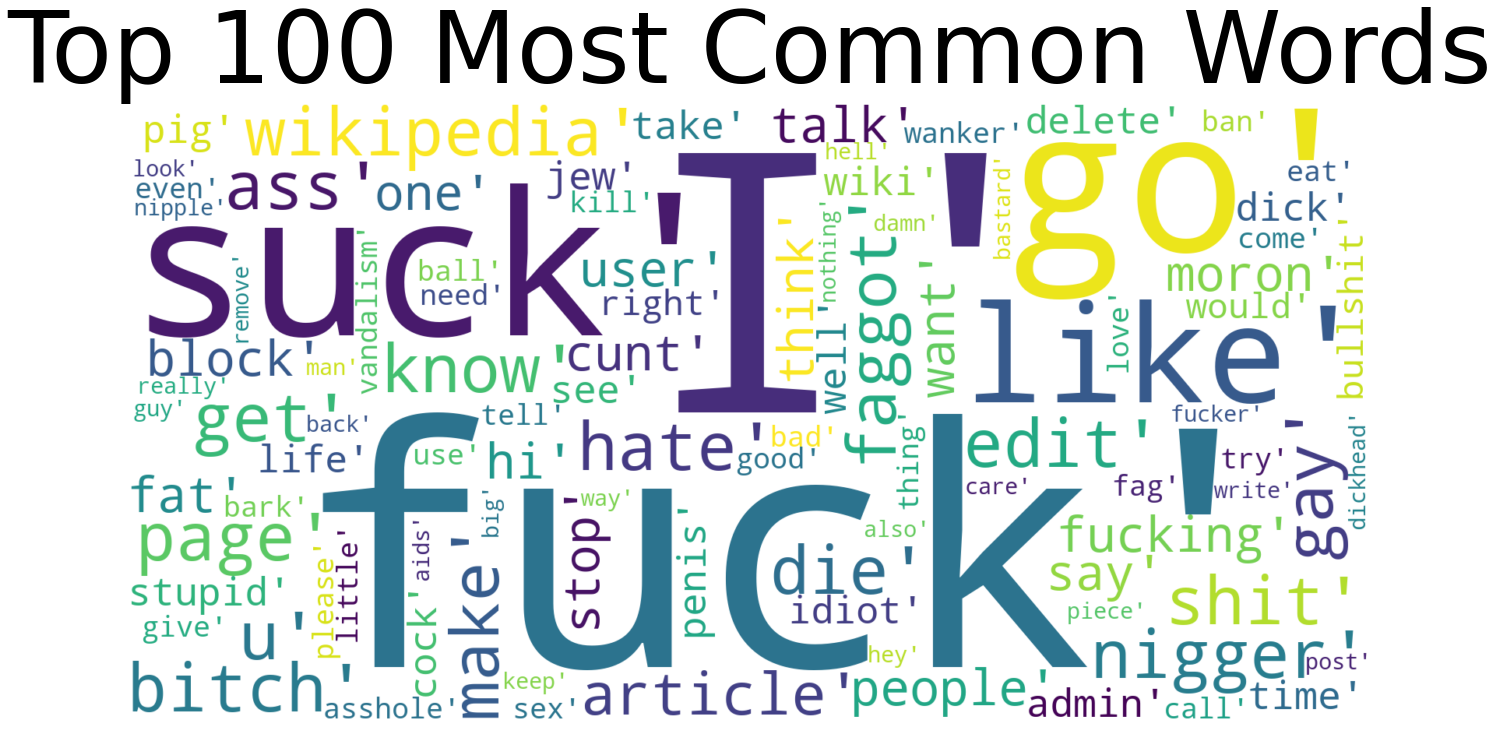

In [25]:
create_word_cloud(word_1_list)

Облако позитивных слов

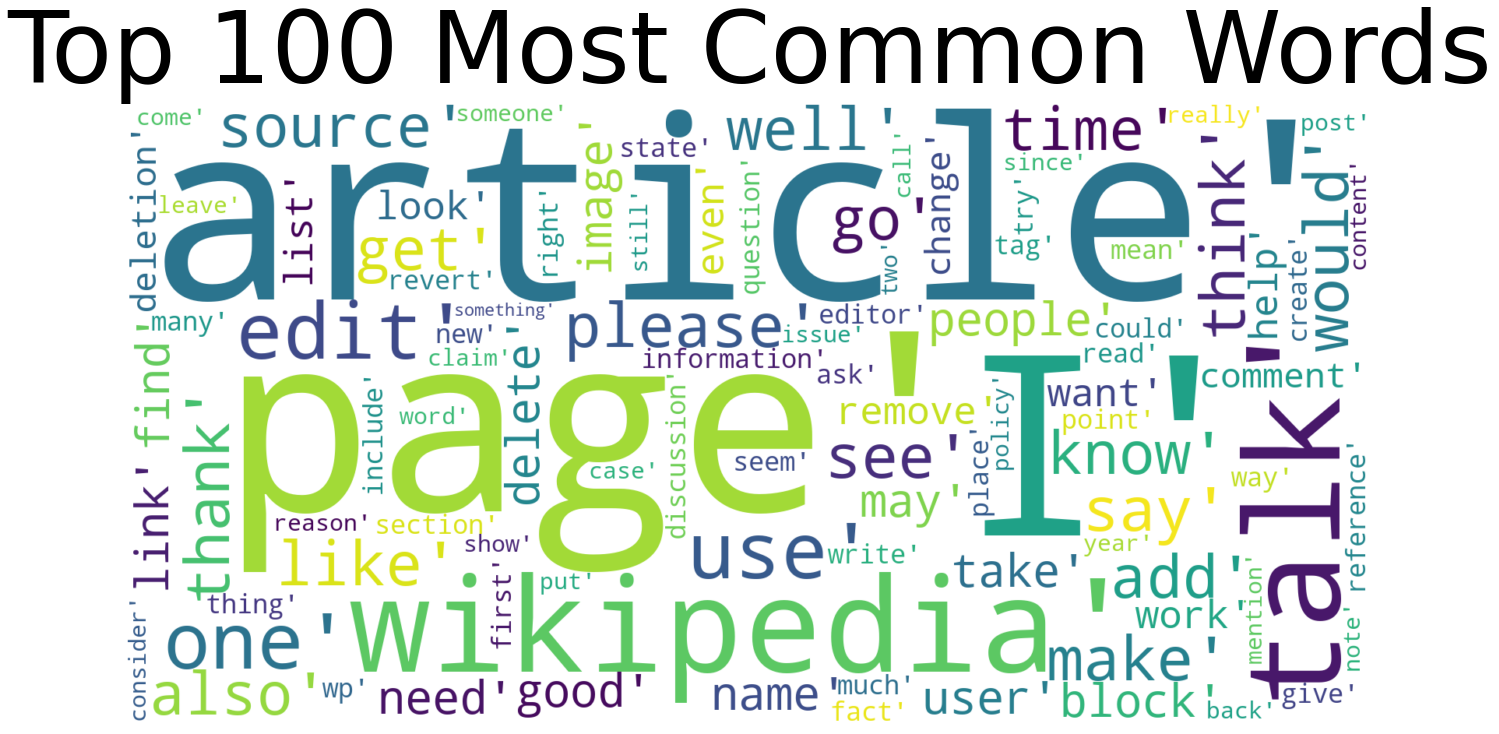

In [26]:
create_word_cloud(word_0_list)

Чтобы каждый раз не делать лемматизацию, сохраним ее в файл

In [27]:
# X.to_csv("datasets/toxic_comments_lemm.csv", index=False)
# X = pd.read_csv("datasets/toxic_comments_lemm.csv", sep=",", error_bad_lines=False)

# na_index = X[X["text"].isna()].index
# y = y.drop(na_index)
# X = X.drop(na_index)

## Построение моделей

Поделим на тест и трейн

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Проверим

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127433, 2), (31859, 2), (127433,), (31859,))

Сделаем tf-idf

Обозначим стоп слова

In [30]:
stop_words = set(stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stop_words)

In [31]:
X_train_tfidf = tf_idf.fit_transform(X_train["lemm"])
X_test_tfidf = tf_idf.transform(X_test["lemm"])

In [32]:
X_train_tfidf.shape, y_train.shape, X_test_tfidf.shape, y_test.shape

((127433, 132427), (127433,), (31859, 132427), (31859,))

Сделаем сетки для перебора гиперпараметров в моделях. Возьмем логистическую регрессию, lightlgm, catboost. Переберем только learning rate, т.к фитится все очень долго

In [33]:
param_catboost = [
     {
      'n_estimators': [100],
      "learning_rate": [0.1, 0.3]
      }
]

param_lgm = [
     {
      'n_estimators': [500],
      "learning_rate": [0.1, 0.02]
      }
]

param_logreg = [
     {}
]

In [34]:
names = ["catboost", "lgm", "logreg"]
params = [param_catboost, param_lgm, param_logreg]
estimators = [
            CatBoostClassifier(
                            verbose=0,
                            random_state=1,
                            auto_class_weights="Balanced"),
            LGBMClassifier( 
                            random_state=1,
                            class_weight="balanced"),
            LogisticRegression(
                            random_state=1,
                            class_weight="balanced")
            ]

Сделаем гридсерч и сохраним результат

In [35]:
results = []

for estimator, param_grid, name in tqdm(zip(estimators, params, names)):
    print(name)
    gs = GridSearchCV(estimator,
                      param_grid,
                      scoring='f1',
                      refit='f1',
                      n_jobs=8,
                      cv=3)
    gs.fit(X_train_tfidf, y_train)

    result = {}
    result["model"] = name
    result["params"] = gs.best_estimator_.get_params()
    result["estimator"] = gs.best_estimator_
    result["f1"] = gs.best_score_
    results.append(result)

0it [00:00, ?it/s]

catboost


1it [04:25, 265.79s/it]

lgm


2it [07:13, 207.97s/it]

logreg


3it [07:18, 146.10s/it]


Результаты

In [36]:
df_results = pd.DataFrame(results)
df_results.sort_values(by="f1", ascending=False, inplace=True)
df_results[["model", "f1"]]

,model,f1
1,lgm,0.762833
2,logreg,0.751583
0,catboost,0.736894


Лучшая модель - lgm

Проверим ее на тесте

In [37]:
best_model = df_results["estimator"][1]

In [38]:
f1_test = f1_score(y_test, best_model.predict(X_test_tfidf))
f1_test

0.7689868857184031

Результат f1 выше требуемого

## Вывод

Нам были даны исторические данные интернет-магазина. Нужно было посмотрить модель для поиска токсичных комментариев для отправки их на модерацию. Мы сделали обработку данных, перебором гиперпараметров нашли, что лучшая модель для данной задачи - LightGBM(learning rate = 0.02, estimators=500). Параметр f1 на тесте равен 0.768, что выше требуемого заказчиком в описании задачи 